In [53]:
import pandas as pd
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Get S&P 500 tickers 
def get_sp500_tickers(sample_size=500):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]    
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [55]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2022-09-30", end="2024-09-30")
        data[i] = stock_data['Adj Close']
    return data

In [56]:
# Perform the ADF test for stationarity
def adf_test(series):         
    result = adfuller(series)
    return result[1]  # Return p-value

In [57]:
# Calculate z-score for the residuals
def calculate_zscore(residuals):
    mean = residuals.rolling(window=50).mean()
    std = residuals.rolling(window=50).std()
    zscore = (residuals - mean) / std
    return zscore

In [58]:
# Function to calculate half-life based on residuals
def calculate_half_life(residuals):
    residuals_lag = residuals.shift(1).dropna()
    delta_residuals = (residuals - residuals_lag).dropna()
    
    # Regress delta_residuals on residuals_lag to estimate half-life
    regression = OLS(delta_residuals, residuals_lag).fit() # fit() method is called on this object for fitting the regression line to the data.
    half_life = -np.log(2) / regression.params[0] # -ln(2)/slope of the regression
    
    return half_life

In [59]:
def get_start_dates(data):
    start_dates = {}
    for ticker in data.columns:
        start_date = data[ticker].first_valid_index()  # Get the first valid index (date)
        if start_date is not None:
            start_dates[ticker] = start_date.strftime('%Y-%m-%d')  # Convert to string format
        else:
            start_dates[ticker] = None  # Handle cases with no valid dates
    return start_dates

In [60]:
# %% Cointegration test between pairs of stocks with ADF and half-life calculation
def cointegration_test(data, start_dates):
    pairs = []
    results = []
    residuals_dict = {}

    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()

            # Align x and y by matching labels (dates)
            x, y = x.align(y, join='inner')

            # Check if start dates are the same
            if start_dates[tickers[i]] != start_dates[tickers[j]]:
                continue  # Disconsider this pair if start dates are not the same

            # Skip to the next pair if x and y do not have the same size
            if len(x) != len(y) or x.empty or y.empty:
                continue

            try:
                # Perform the cointegration test
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue

            if p_value < 0.05:  # Cointegration threshold
                # Ratio between the two prices
                ratio = x / y
                adf_p_value = adf_test(ratio)

                if adf_p_value < 0.05:  # ADF stationarity threshold
                    # Store the residuals from the OLS regression
                    ols_result = OLS(x, y).fit()
                    residuals = ols_result.resid

                    # Calculate half-life based on residuals
                    half_life = calculate_half_life(residuals)

                    pairs.append((tickers[i], tickers[j]))
                    results.append((tickers[i], tickers[j], score, p_value, adf_p_value, half_life))
                    residuals_dict[(tickers[i], tickers[j])] = residuals

    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value', 'Half-life'])
    return results_df, residuals_dict

In [61]:
# %% Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Get start dates for each stock
start_dates = get_start_dates(historical_data)

# Cointegration test
results_df, residuals_dict = cointegration_test(historical_data, start_dates)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-09-30 -> 2024-09-30)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********

500
historical_data:                   UDR        ODFL  BF.B       FTNT        EQIX        NDSN  \
Date                                                                         
2022-09-30  38.330730  123.220848   NaN  49.130001  546.545471  207.615707   
2022-10-03  38.744278  129.709534   NaN  50.959999  556.211243  213.806931   
2022-10-04  38.955647  135.301712   NaN  52.680000  564.791321  219.372162   
2022-10-05  37.751781  134.969833   NaN  53.590000  555.740417  218.335419   
2022-10-06  36.566292  137.292892   NaN  53.740002  535.582703  216.457535   

                 MTCH        AXON        AMGN       GRMN  ...        SYF  \
Date                                                      ...              
2022-09-30  47.750000  115.750000  211.692886  76.507050  ...  26.707781   
2022-10-03  50.279999  115.970001  216.426407  78.469505  ...  28.289972   
2022-10-04  51.450001  120.949997  218.849503  79.545982  ...  30.014278   
2022-10-05  51.040001  123.290001  219.600845  79.21

In [100]:
# Filter pairs based on cointegration first
cointegrated_pairs = results_df[results_df['Cointegration p-value'] < 0.05]

# Among cointegrated pairs, apply ADF test and half-life ranking
adf_filtered_results = cointegrated_pairs[cointegrated_pairs['ADF p-value'] < 0.05]

# Sort by half-life to prioritize pairs with faster mean reversion
sorted_results = adf_filtered_results.sort_values(by='Half-life', ascending=True)

# Take top 5 cointegrated pairs
top_5_pairs = sorted_results.iloc[:5]

print(len(ticks))
print("historical_data:", historical_data.head())
print("results_df:", results_df.head())
print("cointegrated_pairs:", cointegrated_pairs.head())
print("adf_filtered_results", adf_filtered_results.head())
print("sorted_results", adf_filtered_results.head())

500
historical_data:                   UDR        ODFL  BF.B       FTNT        EQIX        NDSN  \
Date                                                                         
2022-09-30  38.330730  123.220848   NaN  49.130001  546.545471  207.615707   
2022-10-03  38.744278  129.709534   NaN  50.959999  556.211243  213.806931   
2022-10-04  38.955647  135.301712   NaN  52.680000  564.791321  219.372162   
2022-10-05  37.751781  134.969833   NaN  53.590000  555.740417  218.335419   
2022-10-06  36.566292  137.292892   NaN  53.740002  535.582703  216.457535   

                 MTCH        AXON        AMGN       GRMN  ...        SYF  \
Date                                                      ...              
2022-09-30  47.750000  115.750000  211.692886  76.507050  ...  26.707781   
2022-10-03  50.279999  115.970001  216.426407  78.469505  ...  28.289972   
2022-10-04  51.450001  120.949997  218.849503  79.545982  ...  30.014278   
2022-10-05  51.040001  123.290001  219.600845  79.21

In [102]:
# %% Function to plot stock prices
def plot_stocks(stock1, stock2, historical_data):
    plt.figure(figsize=(14, 8))
    
    # Plot stock1 price
    plt.plot(historical_data[stock1], label=stock1, color='blue', linewidth=2)
    
    # Plot stock2 price
    plt.plot(historical_data[stock2], label=stock2, color='orange', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} vs {stock2} Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# %% Plot Residuals
def plot_residuals(residuals):
    plt.figure(figsize=(12, 8))
    
    # Plot the residuals of Stock 1 to Stock 2
    plt.plot(residuals, label='Residuals', color='green', linewidth=2)
    
    # Labels and title
    plt.title('Cointegrating Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True)
    plt.show()

# %% Plot residuals z-score
def plot_zscore(zscore):
    plt.figure(figsize=(12, 8))
    plt.plot(zscore, label='Residuals Z-Score', color='gray', linewidth=1)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    plt.axhline(y=1, color='green', linestyle='--', linewidth=1, label='1')
    plt.axhline(y=2, color='green', linestyle='--', linewidth=1, label='2')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='-1')
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2')

    # Labels and title
    plt.title('Residuals Z-Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Z-Score')
    plt.legend()
    plt.show()


In [103]:
# %% Define backtest using z-score signals
def backtest_zscore_strategy(stock1_prices, stock2_prices, zscore_residuals):
    positions = []
    returns = []

    position = None
    entry_stock1_price = None
    entry_stock2_price = None

    for i in range(len(zscore_residuals)):
        # Exit long position when z-score goes above 0 (mean reversion)
        if position == 'long' and zscore_residuals.iloc[i] >= 1.9:
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the long position
            long_return = (exit_stock1_price - entry_stock1_price) / entry_stock1_price
            short_return = (entry_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(long_return + short_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Exit short position when z-score goes below 0 (mean reversion)
        elif position == 'short' and zscore_residuals.iloc[i] <= -1.9:
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the short position
            long_return = (exit_stock2_price - entry_stock2_price) / entry_stock2_price
            short_return = (entry_stock1_price - exit_stock1_price) / entry_stock1_price
            returns.append(long_return + short_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Enter long position when z-score drops below -1
        if position is None and zscore_residuals.iloc[i] <= -2:
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            position = 'long'
            positions.append(('long', i))

        # Enter short position when z-score rises above 1
        elif position is None and zscore_residuals.iloc[i] >= 2:
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            position = 'short'
            positions.append(('short', i))

    return positions, returns

In [104]:
# %% Initialize dictionaries to store results for top 3 pairs
overall_returns = {}
sharpe_ratios = {}
all_positions = {}

for idx, row in top_5_pairs.iterrows():
    stock1, stock2 = row['Stock 1'], row['Stock 2']

    # Get residuals for the pair
    residuals = residuals_dict[(stock1, stock2)]
    
    # Calculate z-score of residuals
    zscore = calculate_zscore(residuals)

    stock1_prices = historical_data[stock1]
    stock2_prices = historical_data[stock2]

    # Plot stock prices, residuals, and z-scores
    #plot_stocks(stock1, stock2, historical_data)
    #plot_residuals(residuals)
    #plot_zscore(zscore)

    # Backtest strategy for this pair
    positions, returns = backtest_zscore_strategy(stock1_prices, stock2_prices, zscore)
    
    # Store the positions and returns for each pair
    overall_returns[(stock1, stock2)] = returns
    all_positions[(stock1, stock2)] = positions

    # Calculating risk-free rate
    risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
    daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

    # Convert returns to a NumPy array
    returns_array = np.array(returns)

    # Excess returns (returns - daily risk-free rate)
    excess_returns = returns_array - daily_risk_free_rate

    # Mean of excess returns
    mean_excess_return = excess_returns.mean()

    # Standard deviation of returns (volatility)
    volatility = returns_array.std()

    sharpe_ratio = mean_excess_return / volatility
    sharpe_ratios[(stock1, stock2)] = sharpe_ratio

# Print results for each pair
for pair in top_5_pairs.itertuples():
    pair_key = (pair[1], pair[2])
    returns = overall_returns[pair_key]
    sum_of_returns = np.sum(returns)  # Calculate the sum of returns

    print(f"Pair: {pair[1]} and {pair[2]}")
    print(f"Returns: {returns}")
    print(f"Sum of Returns: {sum_of_returns}")  # Print the sum of returns
    print(f"Sharpe Ratio: {sharpe_ratios[pair_key]}")
    print(f"Positions: {all_positions[pair_key]}")
    print()

Pair: APA and FICO
Returns: [np.float64(-0.31961299971883905), np.float64(0.041471339471109855), np.float64(-0.5020380556263145), np.float64(0.19886974892397902)]
Sum of Returns: -0.5813099669500648
Sharpe Ratio: -0.5214875476340479
Positions: [('long', 84), ('exit', 193), ('short', 194), ('exit', 253), ('long', 254), ('exit', 375), ('short', 376), ('exit', 404), ('long', 406)]

Pair: FE and CMS
Returns: [np.float64(0.08521549769894439), np.float64(0.07308726570184171), np.float64(0.024227183733510654), np.float64(0.04223138181972037), np.float64(0.06545880235210401), np.float64(0.048917437056317695), np.float64(0.03882126468933991)]
Sum of Returns: 0.3779588330517787
Sharpe Ratio: 2.7195888041921257
Positions: [('short', 74), ('exit', 86), ('long', 87), ('exit', 131), ('long', 144), ('exit', 247), ('short', 248), ('exit', 305), ('short', 341), ('exit', 357), ('long', 358), ('exit', 428), ('short', 438), ('exit', 491), ('long', 492)]

Pair: GOOG and GOOGL
Returns: [np.float64(0.0086710

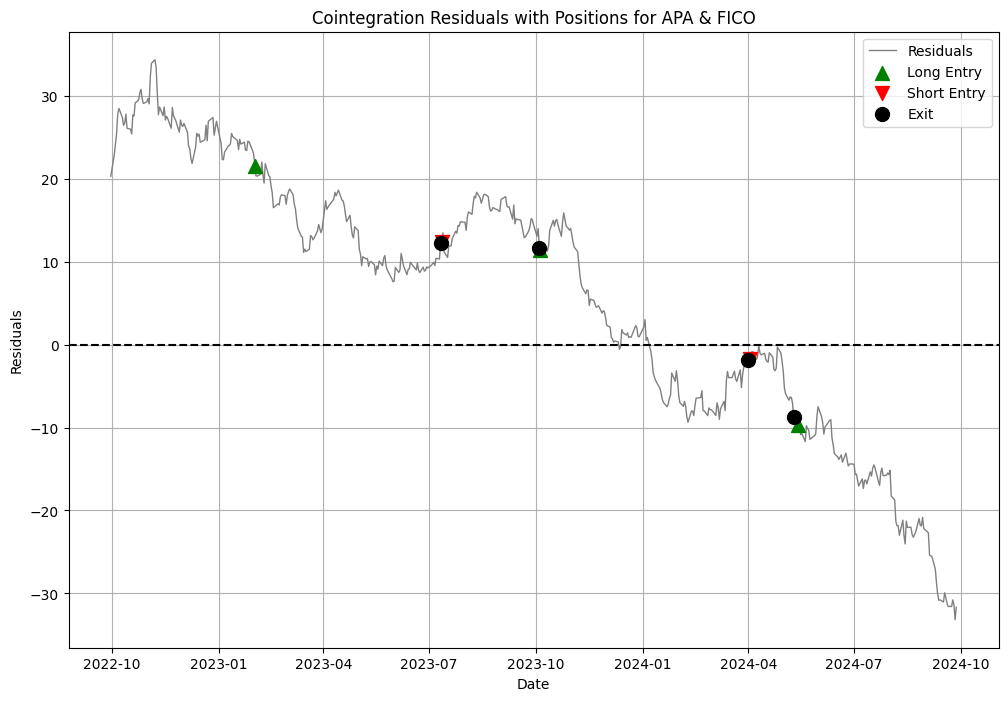

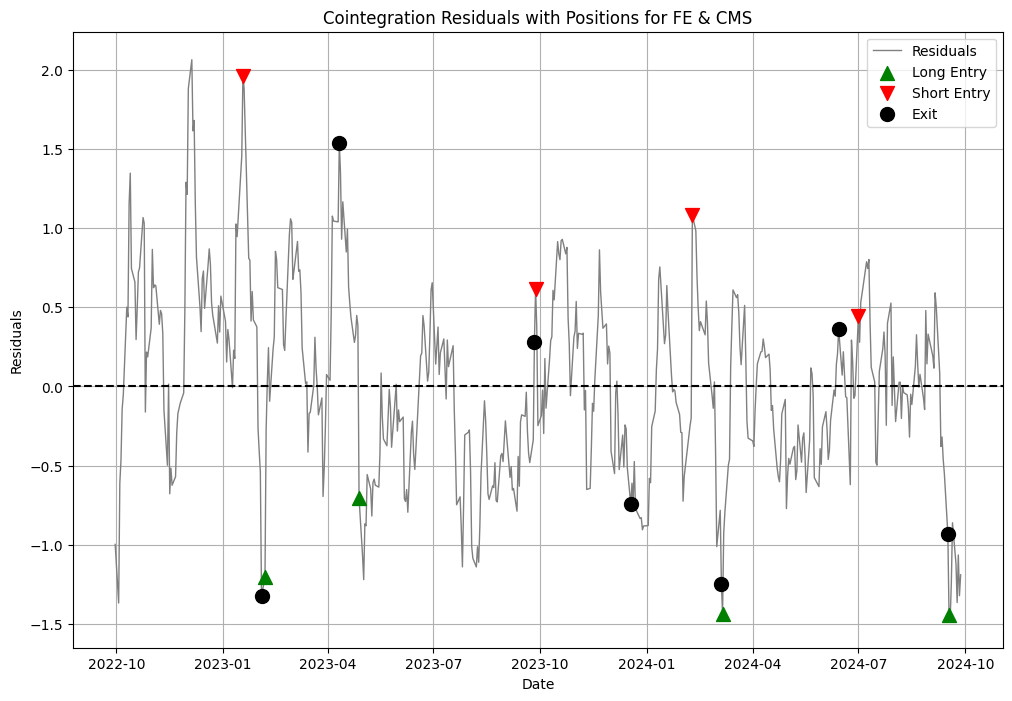

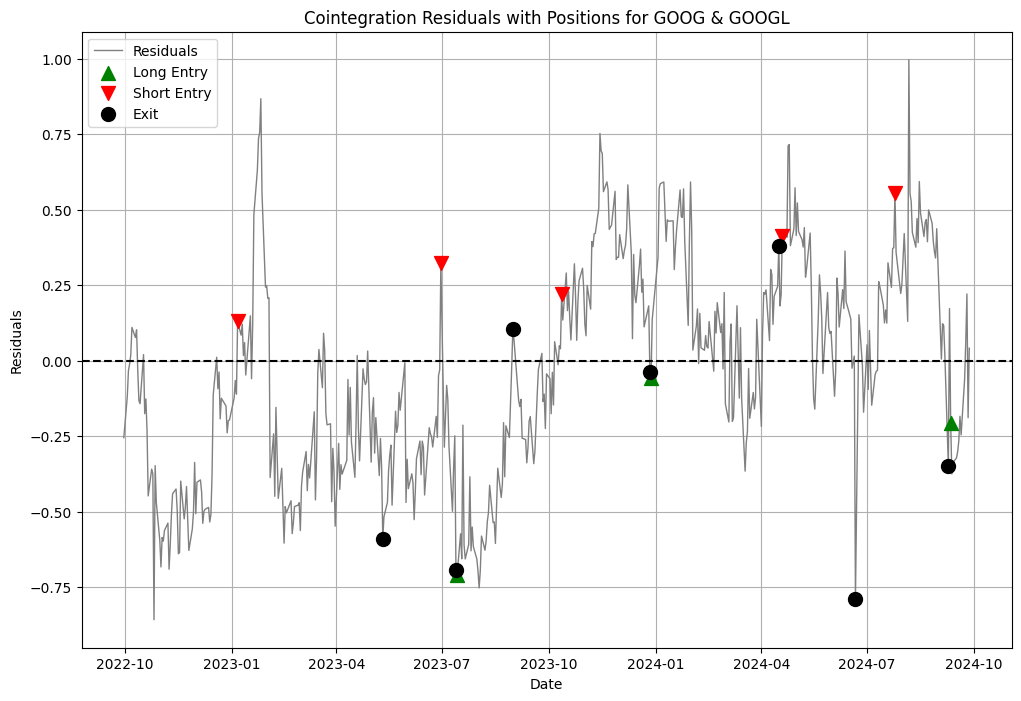

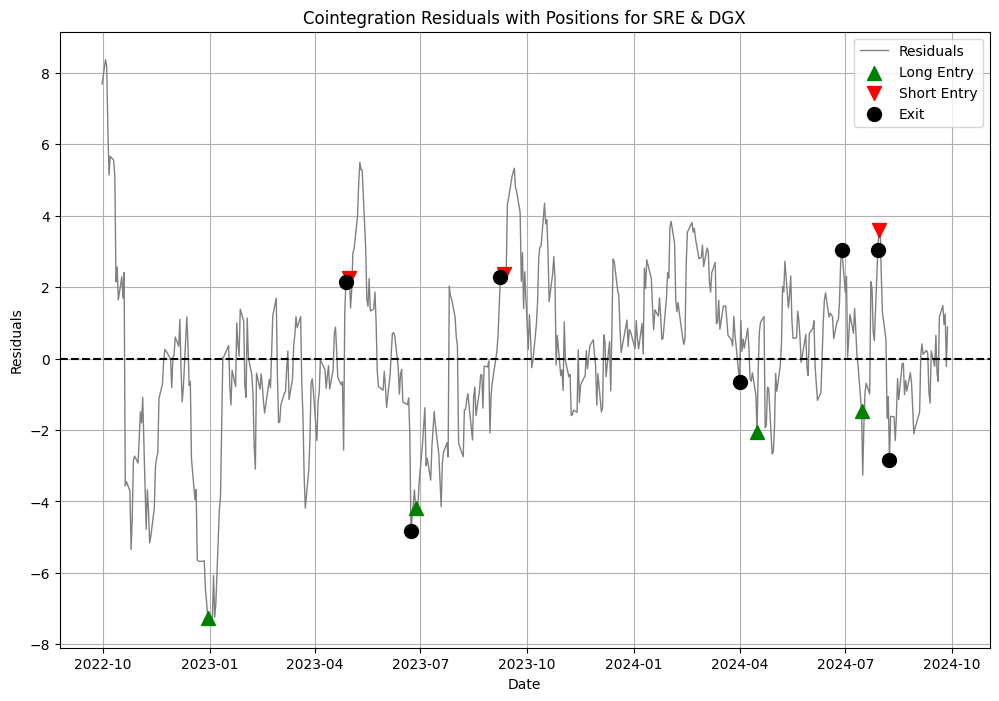

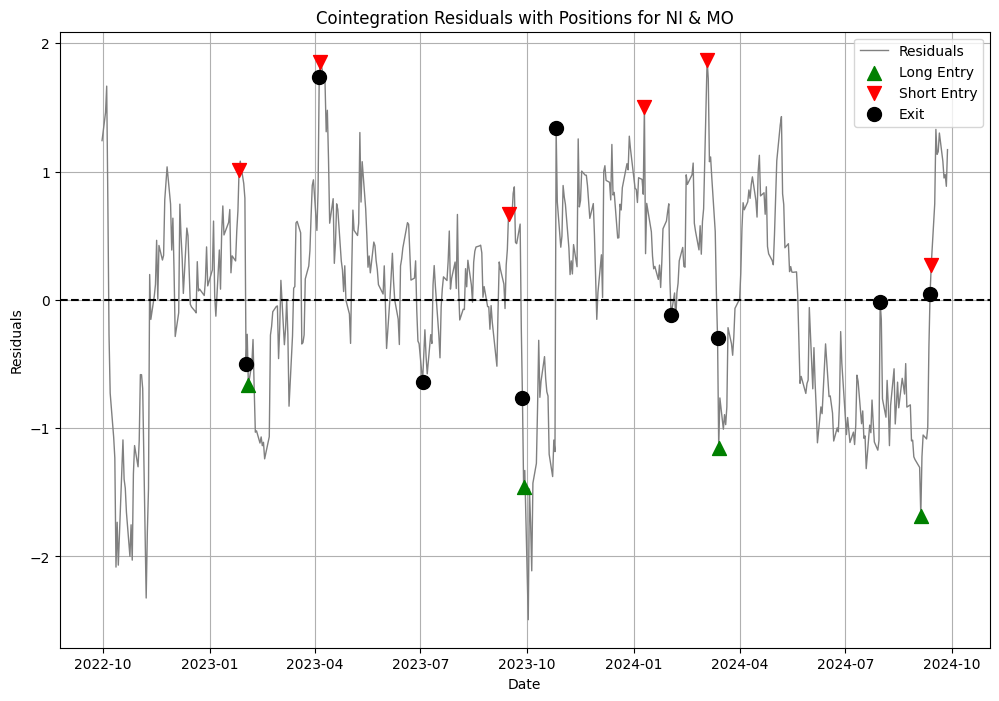

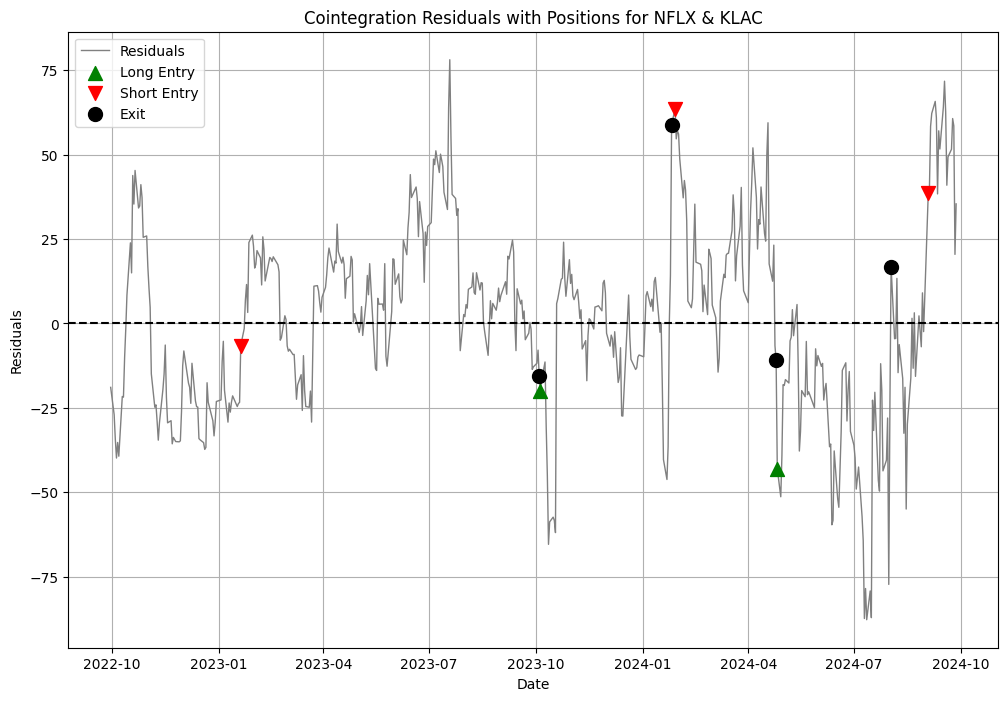

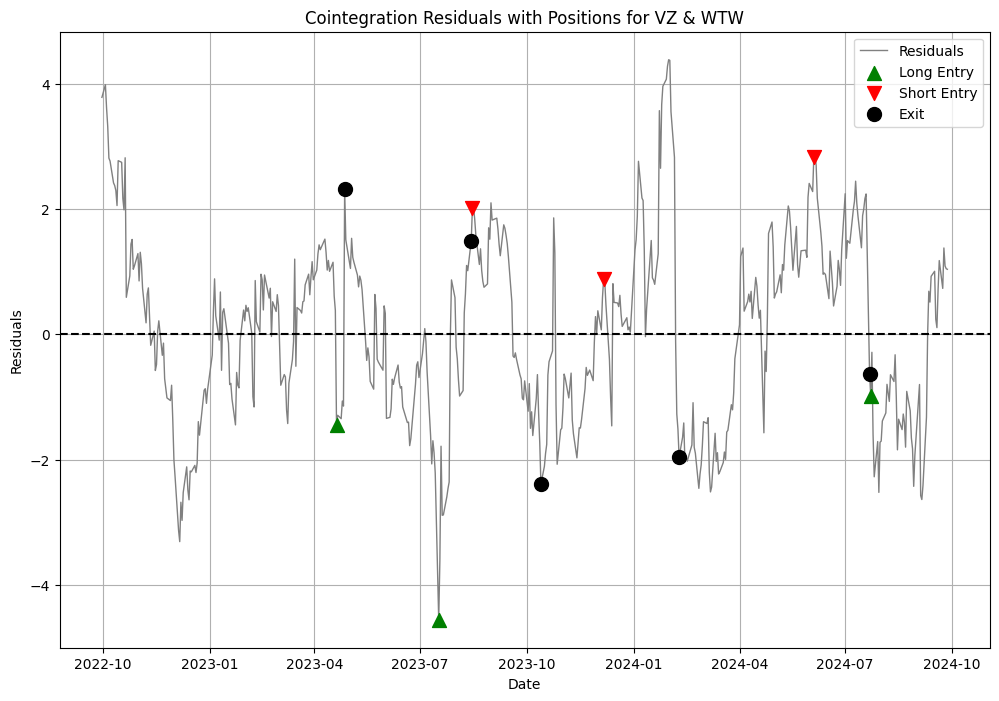

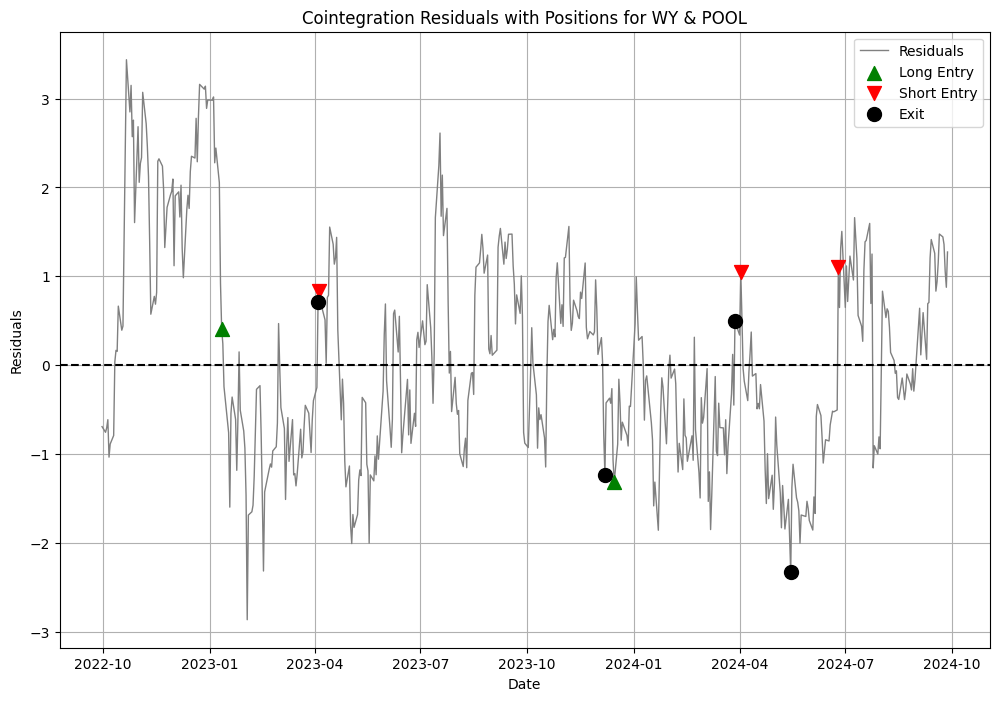

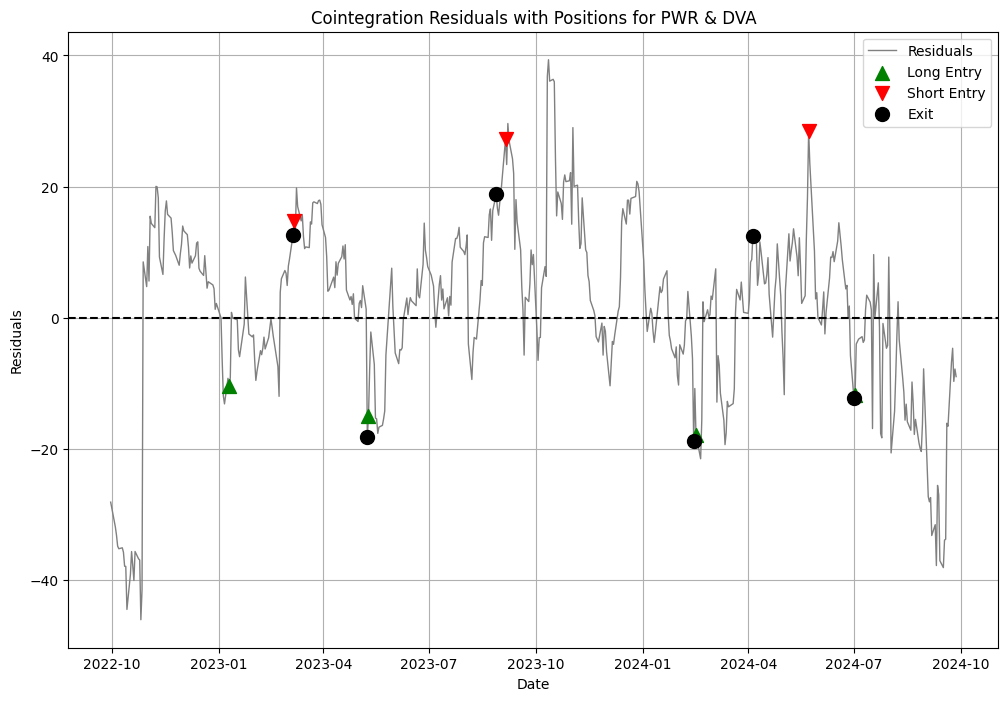

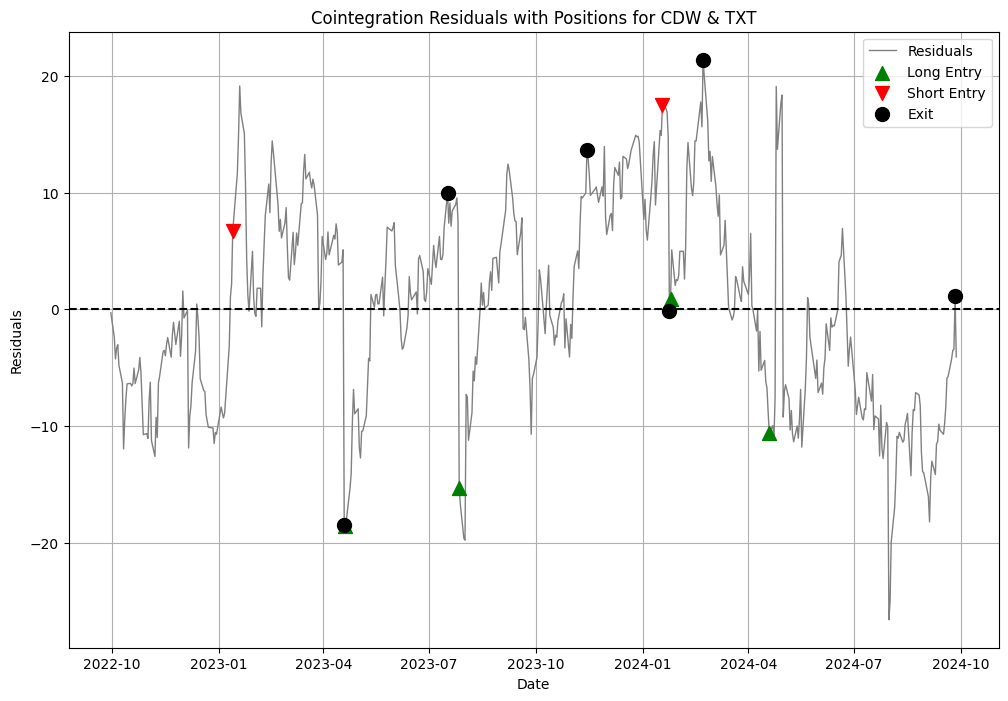

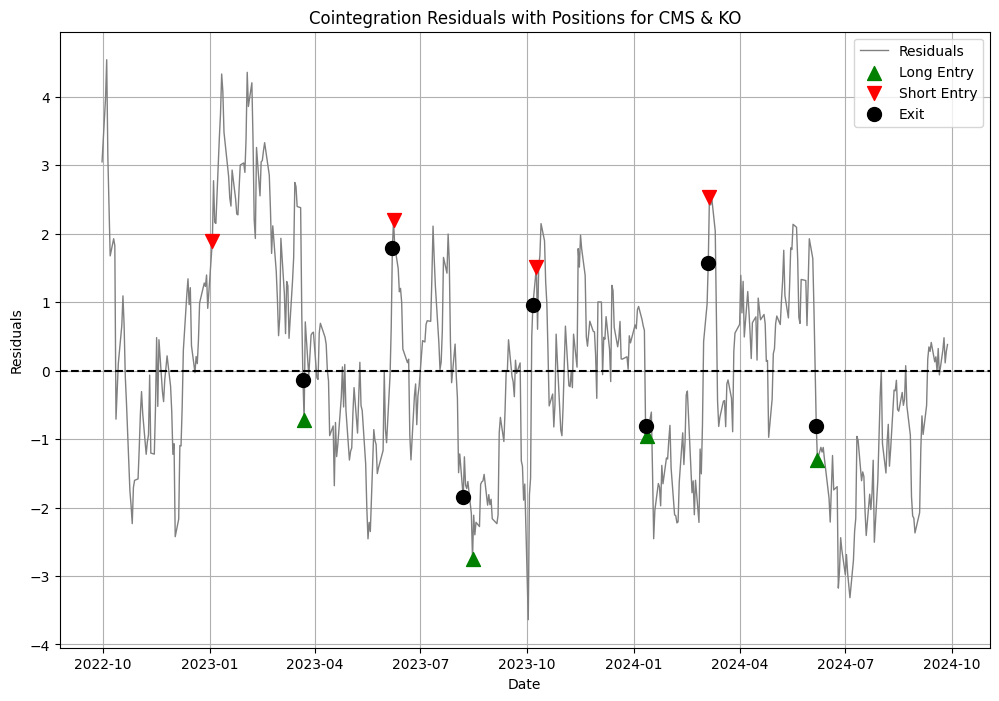

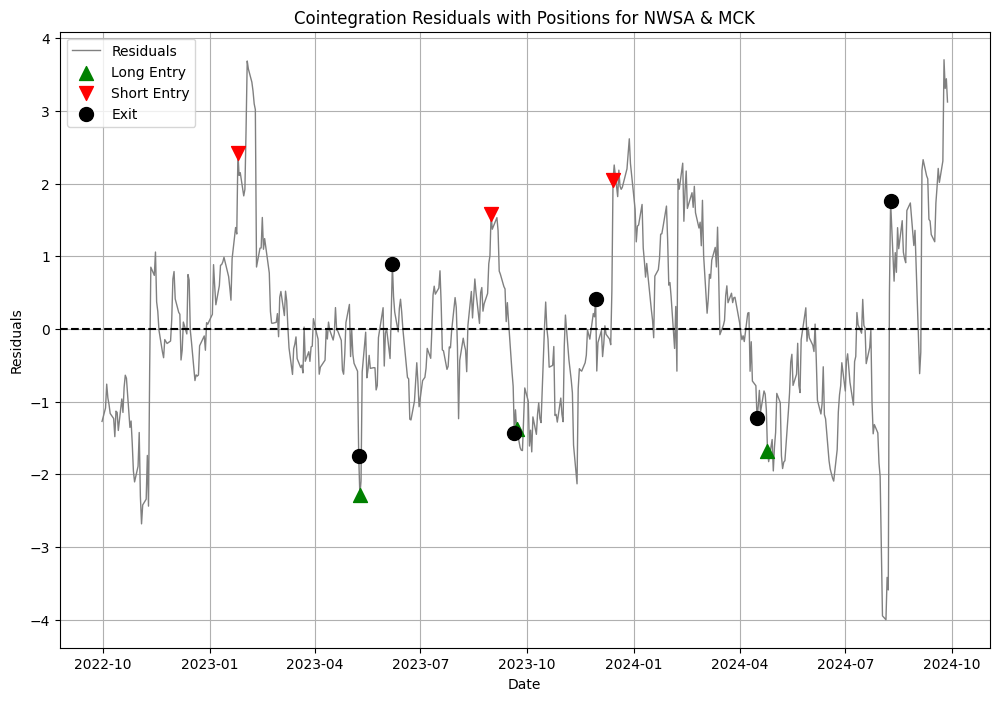

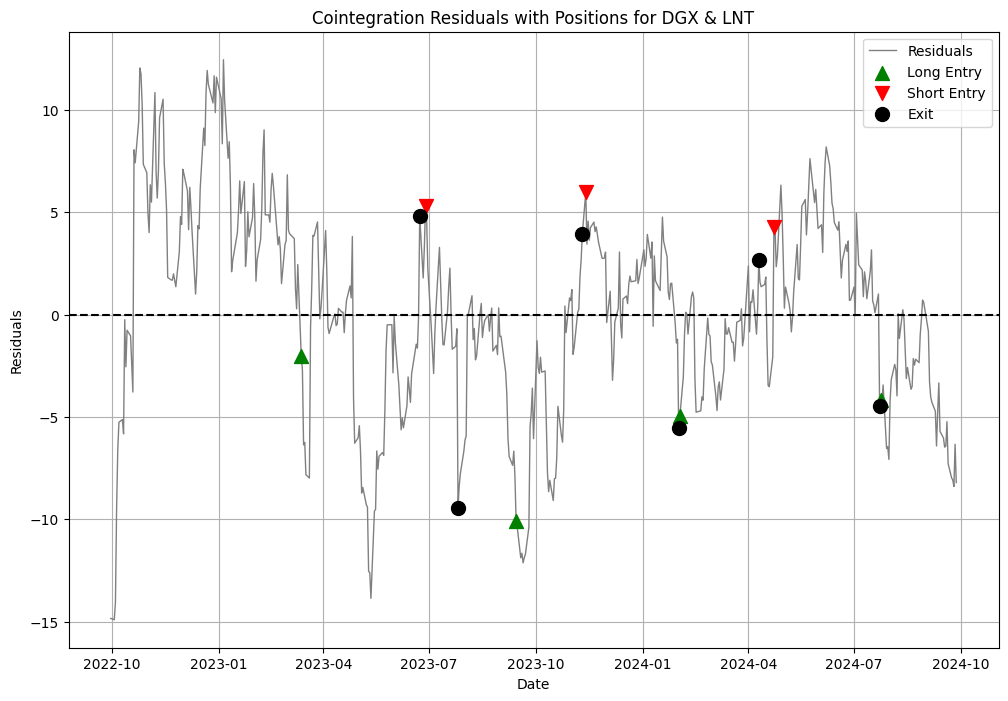

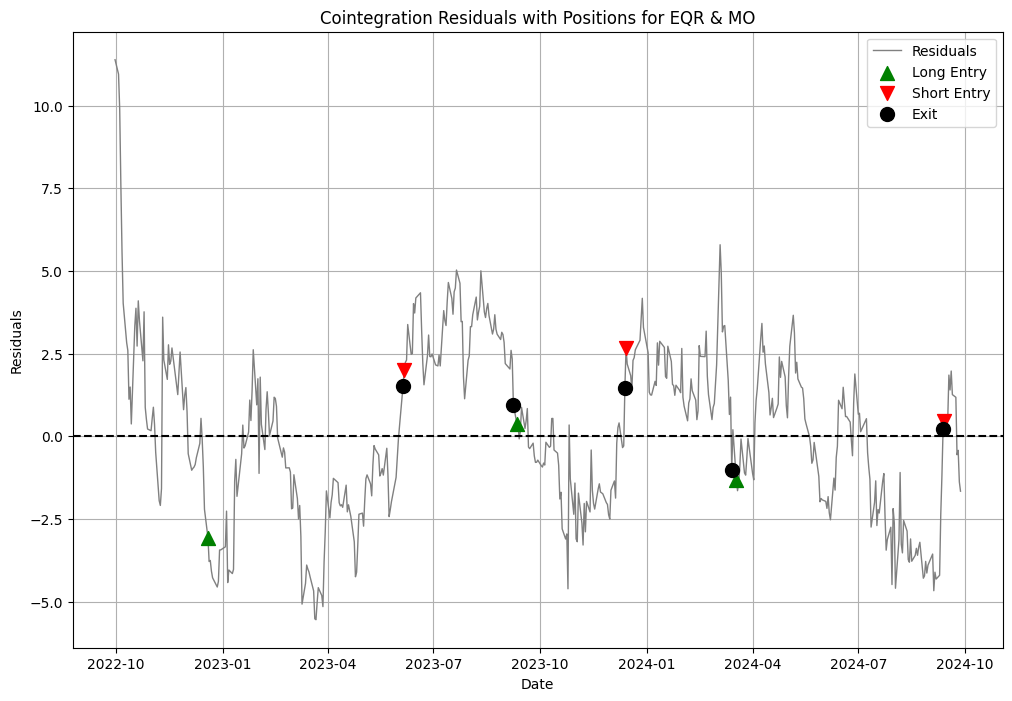

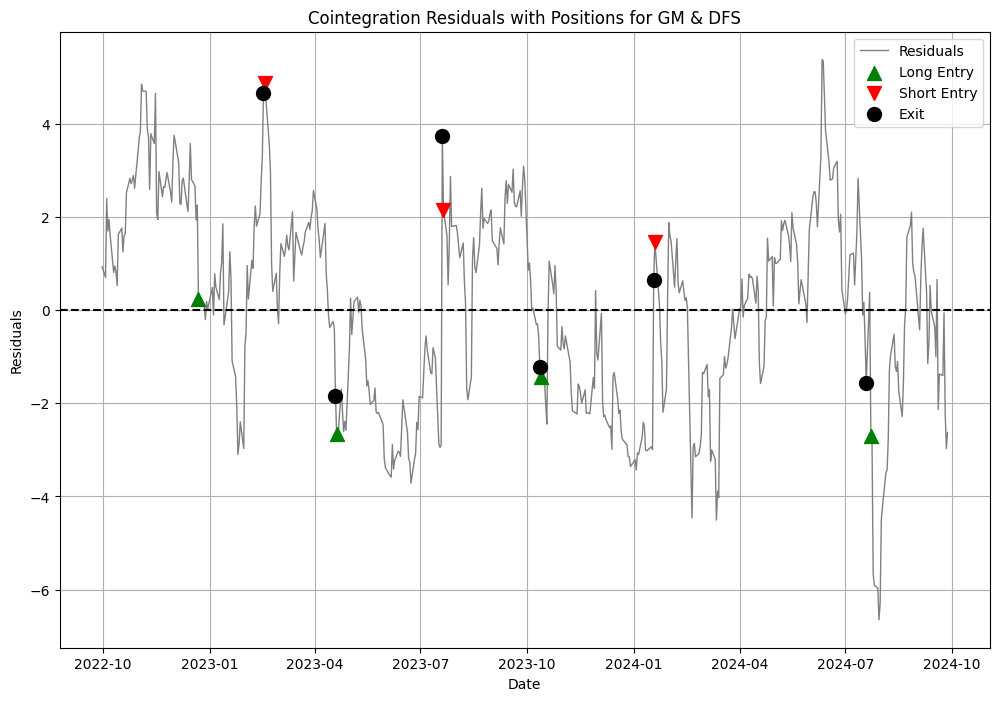

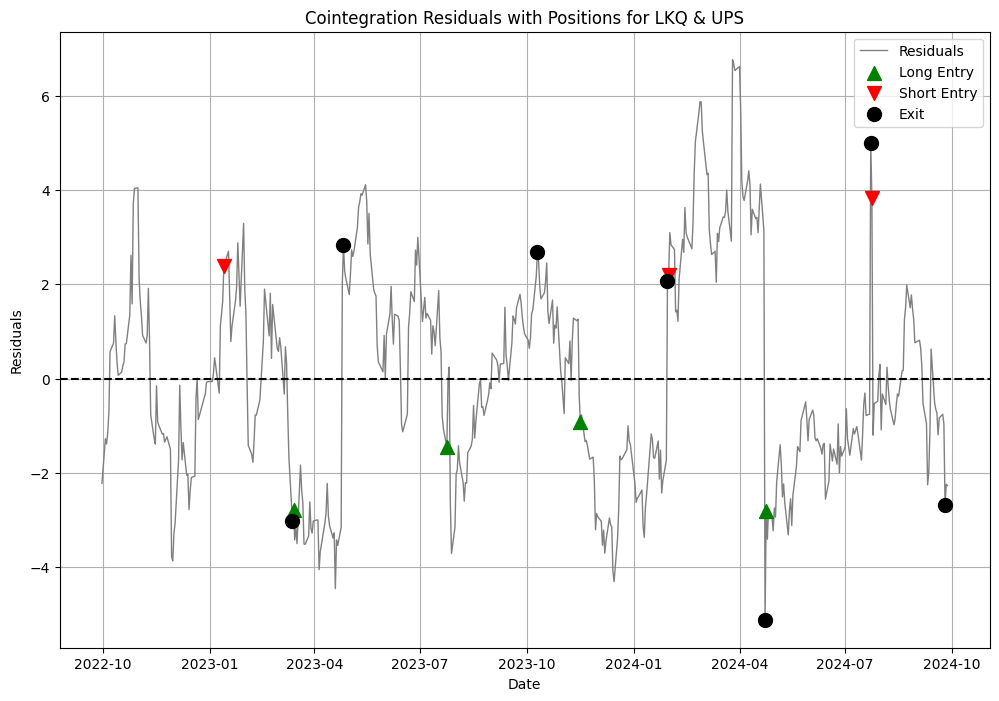

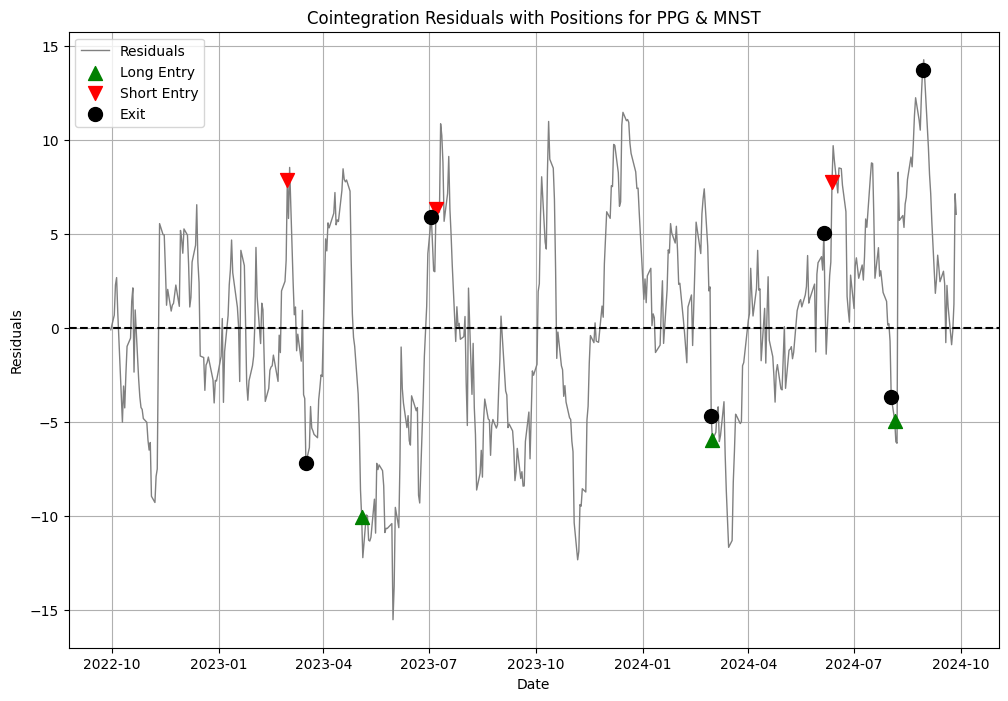

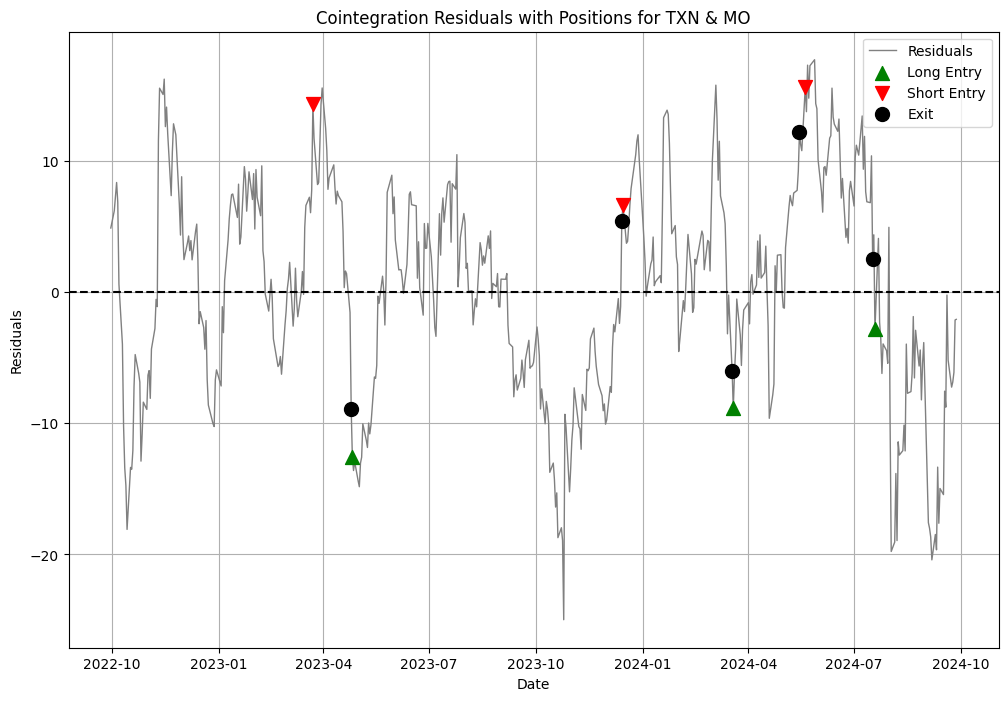

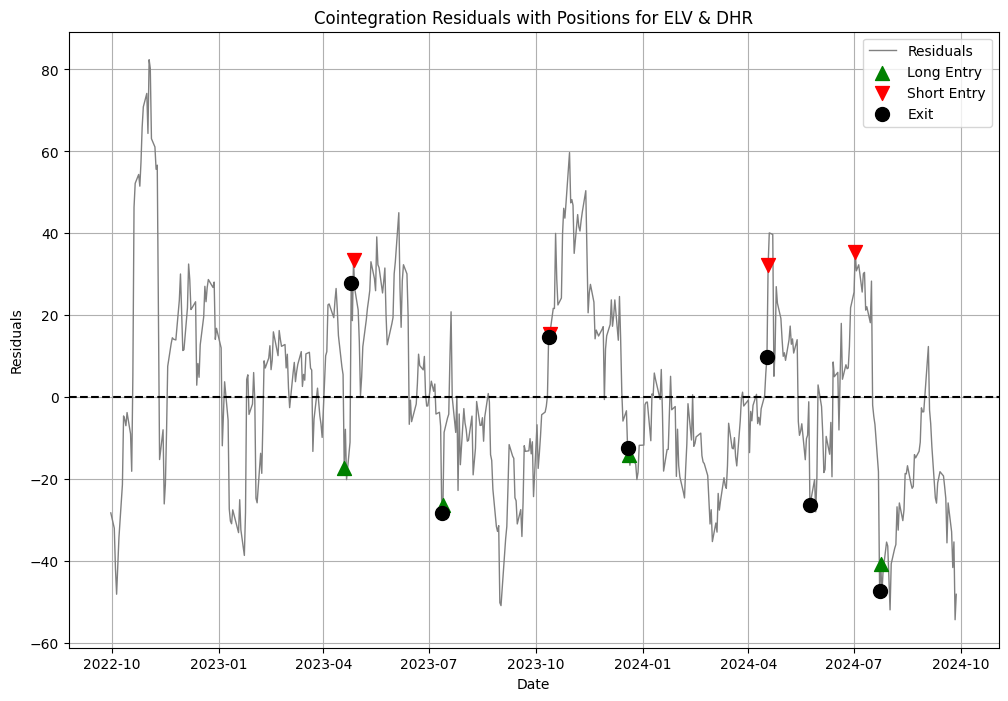

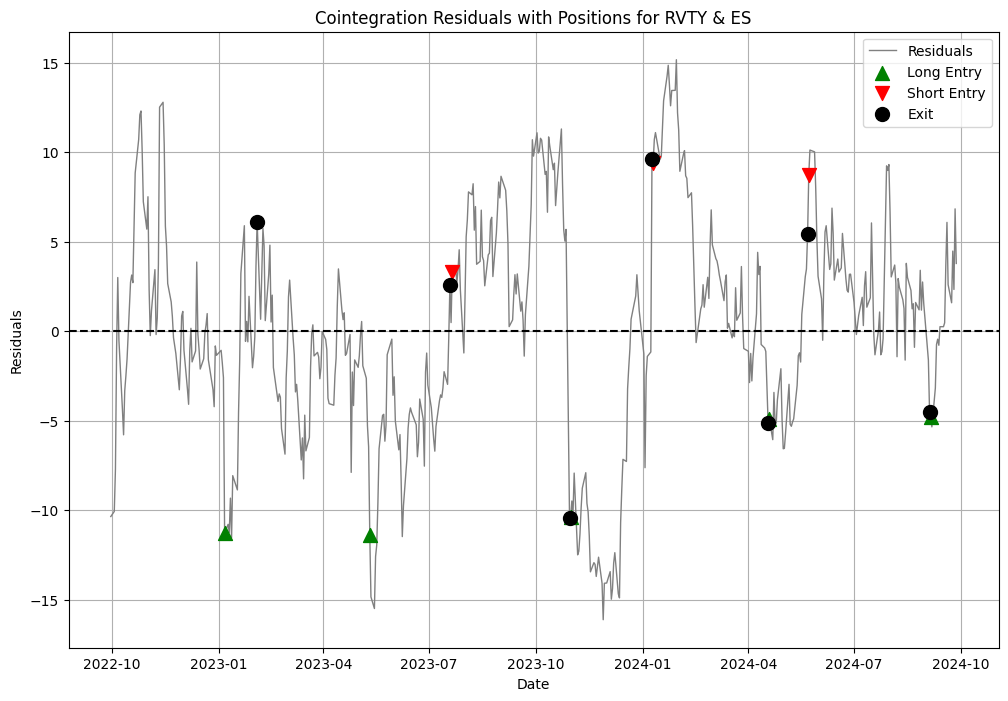

In [95]:
# Function to plot residuals with positions
def plot_residuals_with_positions(residuals, positions, stock_pair):
    plt.figure(figsize=(12, 8))
    plt.plot(residuals.index, residuals, label="Residuals", color='gray', linewidth=1)

    # Plot long, short, and exit positions
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']

    plt.scatter(residuals.index[long_positions], residuals.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    plt.scatter(residuals.index[short_positions], residuals.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    plt.scatter(residuals.index[exit_positions], residuals.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)

    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"Cointegration Residuals with Positions for {stock_pair}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

# Now call the plot function for the top 3 pairs
for idx, row in top_5_pairs.iterrows():
    stock1, stock2 = row['Stock 1'], row['Stock 2']
    
    # Get the residuals and positions from the backtest for each pair
    residuals = residuals_dict[(stock1, stock2)]
    positions = all_positions[(stock1, stock2)]
    
    # Plot residuals with positions for this pair
    plot_residuals_with_positions(residuals, positions, stock_pair=f"{stock1} & {stock2}")